# Clasificación de _fake news_ con BERT

En este notebook vamos a ajustar un modelo preentrenado para tratar de clasificar las noticias falsas de un conjunto de datos predefinido de Kaggle. El modelo que hemos escogido es BERT, un modelo del lenguaje entrenado por Google y a disposición del público general en Kaggle.

In [1]:
# importamos las librerias de deep learning
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

# librerias para limpiar los datos
import matplotlib.pyplot as plt
import pandas as pd
import string
import numpy as np


# librerias para preparar los datos para entrenar y visualizar resultados
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# guardar y cargar modelos
from joblib import dump, load

#tf.get_logger().setLevel('ERROR')

2024-01-12 09:11:22.650229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 09:11:22.650282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 09:11:22.703240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 09:11:22.814283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 09:11:24.005804: W tensorflow/compiler/tf2

In [27]:
# Cargamos el dataframe
df = pd.read_csv("Data/WELFake_Dataset.csv")

In [28]:
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


Primero vemos el número de valores nulos y decidimos qué hacer con ellos:

In [29]:
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [30]:
# Tenemos un porcentaje muy pequeño de nulos, así que es recomendable eliminarlos
df = df.dropna()

In [31]:
# Eliminamos la columna de los ids del dataframe
df = df.drop("Unnamed: 0", axis=1)

In [32]:
# vemos si el df está balanceado
df.loc[:, 'label'].value_counts(normalize=True)

label
1    0.510351
0    0.489649
Name: proportion, dtype: float64

In [33]:
# pasamos el texto a minusculas
df.loc[:, ['text', 'title']] = df.loc[:, ['text', 'title']].apply(lambda x: x.str.lower())

In [34]:
df.to_csv('Data/df_limpio.csv', index=False)

## Definición y entrenamiento de BERT

Como vamos a hacer varias pruebas, vamos primero a definir una función que defina el modelo. Hay varias versiones de BERT, así que las guardamos como variable global para poder cambiar de versión y hacer distintas pruebas.

In [10]:
# escogemos un small bert para probar
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [4]:
# funcion que define el modelo
def define_bert(bert_model_name, trainable=True):
    # seleccionamos url del modelo que queremos
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
    
    # creamos las capas de preprocesado y encoding
    bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
    bert_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable = trainable, name='BERT_encoder')
    
    # creamos la capa de entrada de texto y la arquitectura del modelo
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    
    # capa de dropout y capa densa de la red
    l = tf.keras.layers.Dropout(0.1, name = 'Dropout')(outputs['pooled_output'])
    l1 = tf.keras.layers.Dense(1, activation=None, name='output')(l)
    
    # modelo final 
    model = tf.keras.Model(text_input, l1)
    print(model.summary())
    return model

In [5]:
def train_bert(model, X_train, y_train, epochs=5):
    # creamos el optimizador que utiliza bert
    steps_per_epoch = len(X_train)
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    
    # definimos la funcion de perdida y la metrica a seguir
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
    #print(steps_per_epoch, num_train_steps, num_warmup_steps)
    model.fit(X_train, y_train, epochs = epochs)

## Prueba rápida

Primero, vamos a hacer una prueba para entrenar el modelo sin hacer ninguna modificación al texto de las noticias. Esto es posible porque el modelo ya incluye su propio preprocesado del texto y genera sus propios embeddings en base a su entrenamiento. En específico, BERT es un modelo bidireccional que tiene en cuenta el contexto anterior y posterior de una palabra y en base a ello genera un vector que la representa. BERT ha sido entrenado sobre la Wikipedia en inglés y sobre libros de BookCorpus.

In [17]:
# quitamos el titulo
df = df.drop("title", axis=1)

In [18]:
# dividimos df
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)

In [ ]:
# entrenamos el modelo
model = define_bert('small_bert/bert_en_uncased_L-6_H-128_A-2')
train_bert(model, X_train, y_train, epochs = 5)

In [ ]:
# lo guardamos usando joblib
model.save('models/smallbert_en_uncased_L-6_H-128_A-2')

In [15]:
# lo cargamos para no tener que entrenarlo de nuevo
model = tf.keras.models.load_model('models/smallbert_en_uncased_L-6_H-128_A-2', compile=False)

In [ ]:
# predecimos sobre X_test
yhat = model.predict(X_test)
yhatt = yhat.flatten()

# el modelo nos devuelve números positivos y negativos e interpretamos que cuanto más grandes más probabilidades de ser 1
yhatt

Jaccard Index: 0.9446356548569446
Accuracy: 0.9715310781846985
Precisión: 0.9716201624117277
Recall: 0.9718014393057571
F1-score: 0.9715296688763269


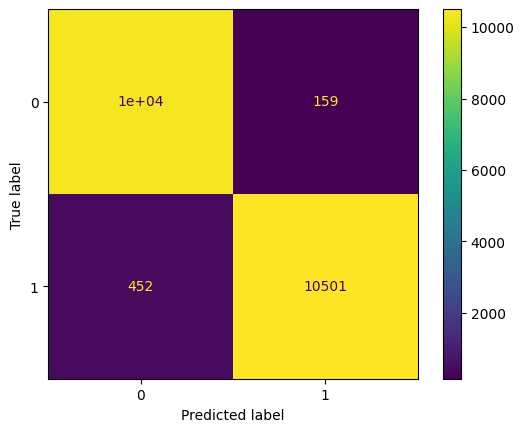

In [28]:
# Vemos las métricas
print("Jaccard Index:", jaccard_score(y_test, yhatt, average = "macro"))
print("Accuracy:"     , accuracy_score(y_test, yhatt))
print("Precisión:"    , precision_score(y_test, yhatt, average = "macro"))
print("Recall:" , recall_score(y_test, yhatt, average = "macro"))
print("F1-score:"     , f1_score(y_test, yhatt, average = "macro"))

cm = confusion_matrix(y_test, yhatt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Incluso en una prueba rápida, con una versión pequeña del modelo que ha tardado unos 35 minutos en entrenar, tenemos una gran precisión, mucho mayor que la de los modelos de machine learning.

## Función entrenadora
Por comodidad, vamos a definir una función que haga todos los pasos anteriores de seguido, y así poder aligerar el código

In [5]:
def train_fit_predict_bert(bert_model_name, X_train, y_train, X_test, y_test, epochs, trainable=True, extra_name=None):
    model = define_bert(bert_model_name, trainable)
    train_bert(model, X_train, y_train, epochs)
    model.save(f'models/{extra_name}_small{bert_model_name.split("/")[1]}')
    yhat = model.predict(X_test).flatten()
    return yhat

In [6]:
# definimos también una para las métricas
def print_metrics(yhat, y_test):
    print("Jaccard Index:", jaccard_score(y_test, yhat, average = "macro"))
    print("Accuracy:"     , accuracy_score(y_test, yhat))
    print("Precisión:"    , precision_score(y_test, yhat, average = "macro"))
    print("Recall:" , recall_score(y_test, yhat, average = "macro"))
    print("F1-score:"     , f1_score(y_test, yhat, average = "macro"))
    
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

## Prueba limpiando los datos

In [35]:
df = pd.read_csv('Data/df_limpio.csv')

In [36]:
df

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last ...",1
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0
3,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1
4,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1
...,...,...,...
71532,russians steal research on trump in hack of u....,washington (reuters) - hackers believed to be ...,0
71533,watch: giuliani demands that democrats apolog...,"you know, because in fantasyland republicans n...",1
71534,migrants refuse to leave train at refugee camp...,migrants refuse to leave train at refugee camp...,0
71535,trump tussle gives unpopular mexican leader mu...,mexico city (reuters) - donald trump’s combati...,0


In [37]:
# quitamos el titulo
df = df.drop("title", axis=1)

In [38]:
# limpieza de texto quitando signos de puntuación
df.loc[:, 'text'] = df.loc[:, 'text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [39]:
df.head()

,text,label
0,no comment is expected from barack obama membe...,1
1,now most of the demonstrators gathered last n...,1
2,a dozen politically active pastors came here f...,0
3,the rs28 sarmat missile dubbed satan 2 will re...,1
4,all we can say on this one is it s about time ...,1


In [40]:
# dividimos df
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)

In [ ]:
# llamamos a nuestra funcion
yhat = train_fit_predict_bert('small_bert/bert_en_uncased_L-6_H-128_A-2', X_train, y_train, X_test, y_test, epochs = 5, extra_name = 'nopunct')

Como antes, cargamos el modelo que ha guardado el código anterior para poder ejecutarlo.

In [15]:
# lo cargamos para no tener que entrenarlo de nuevo
extra_name = 'nopunct'
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'
path = f'models/{extra_name}_small{bert_model_name.split("/")[1]}'
model = tf.keras.models.load_model(path, compile=False)

# predecimos sobre X_test
yhat = model.predict(X_test).flatten()

Jaccard Index: 0.930209380020016
Accuracy: 0.9638896654552231
Precisión: 0.9646258859657837
Recall: 0.9635453655966887
F1-score: 0.9638412914727515


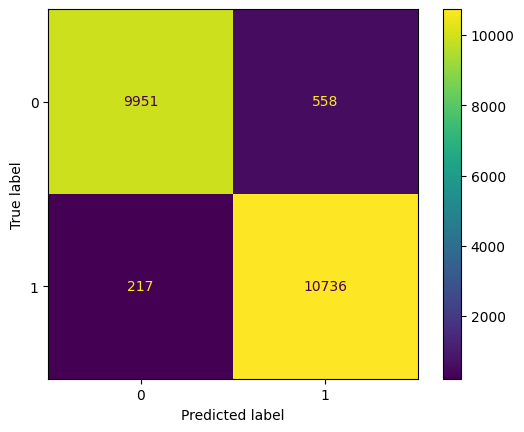

In [42]:
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

Sorprendentemente, los resultados no mejoran significativamente cuando limpiamos los datos. Esto es porque el preprocesamiento de BERT ya hace esta función por nosotros.

## Prueba con la columna `title` incluída.

In [43]:
df = pd.read_csv('Data/df_limpio.csv')

In [44]:
df.loc[:, 'text'] = df.loc[:, ['title', 'text']].sum(axis = 1).iloc[0]

In [46]:
df.head(3)

,title,text,label
0,law enforcement on high alert following threat...,law enforcement on high alert following threat...,1
1,unbelievable! obama’s attorney general says mo...,law enforcement on high alert following threat...,1
2,"bobby jindal, raised hindu, uses story of chri...",law enforcement on high alert following threat...,0


5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                          

INFO:tensorflow:Assets written to: models/doscolumnas_nolimpio_smallbert_en_uncased_L-6_H-128_A-2/assets


671/671 [==============================] - 145s 216ms/step
Jaccard Index: 0.2448280682135868
Accuracy: 0.4896561364271736
Precisión: 0.2448280682135868
Recall: 0.5
F1-score: 0.3287041381251759


/home/alejandro/anaconda3/envs/proyecto2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


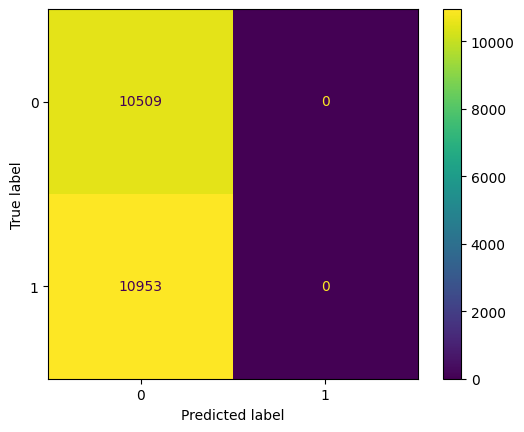

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)
yhat = train_fit_predict_bert('small_bert/bert_en_uncased_L-6_H-128_A-2', X_train, y_train, X_test, y_test, epochs = 5, extra_name = 'doscolumnas_nolimpio')
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

In [15]:
# lo cargamos para no tener que entrenarlo de nuevo
extra_name = 'doscolumnas_nolimpio'
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'
path = f'models/{extra_name}_small{bert_model_name.split("/")[1]}'
model = tf.keras.models.load_model(path, compile=False)

# predecimos sobre X_test
yhat = model.predict(X_test).flatten()
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

En realidad, usar la columna `title` concatenándola al resto del texto no es la forma correcta de concatenar dos frases para pasarlas a BERT, sino que lo ideal es usar tokens especiales de separación para distinguir entre ellas. Además, al tener este BERT una limitación de 128 palabras, algunas noticias no van a caber al completo en los vectores, y menos al añadir el título, así que la precisión va a ser peor.

## Prueba usando solo la columna title.

In [7]:
df = pd.read_csv('Data/df_limpio.csv')

In [8]:
df.head(3)

,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last ...",1
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'title'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)
yhat = train_fit_predict_bert('small_bert/bert_en_uncased_L-6_H-128_A-2', X_train, y_train, X_test, y_test, epochs = 5, extra_name = 'title_nolimpio')
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

Jaccard Index: 0.8270097218697992
Accuracy: 0.9053676265026559
Precisión: 0.9080902704206533
Recall: 0.9062654073894586
F1-score: 0.9053100991187114


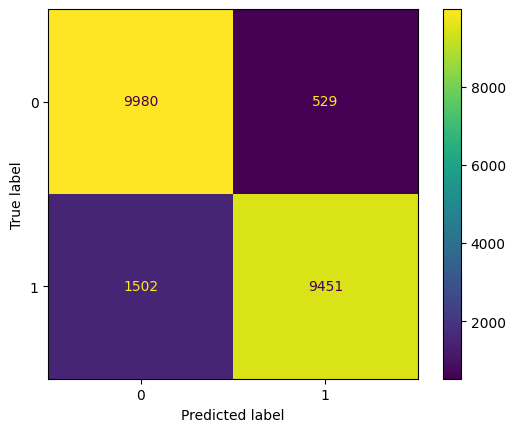

In [10]:
# lo cargamos para no tener que entrenarlo de nuevo
extra_name = 'title_nolimpio'
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'
path = f'models/{extra_name}_small{bert_model_name.split("/")[1]}'
model = tf.keras.models.load_model(path, compile=False)

# predecimos sobre X_test
yhat = model.predict(X_test).flatten()
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

## Prueba sin usar el parámetro `trainable=True`. 
Esto hace que los únicos pesos a ajustar sean los pesos de la capa densa que hemos añadido, pero no se ajustan los de BERT a nuestro problema particular. En este sentido, solo nos estamos sirviendo de BERT para pasar de palabras a vectores contextualizados.

In [11]:
df = pd.read_csv('Data/df_limpio.csv')
df = df.drop('title', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)
yhat = train_fit_predict_bert('small_bert/bert_en_uncased_L-6_H-128_A-2', X_train, y_train, X_test, y_test, epochs = 5, extra_name = 'not_trainable_nolimpio', trainable = False)
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

Jaccard Index: 0.40277530051122507
Accuracy: 0.607585499953406
Precisión: 0.7137759122446696
Recall: 0.6146789337537214
F1-score: 0.559575291638977


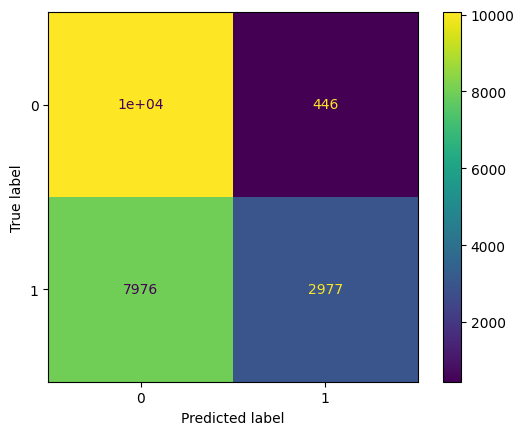

In [14]:
# lo cargamos para no tener que entrenarlo de nuevo
extra_name = 'title_nolimpio'
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'
path = f'models/{extra_name}_small{bert_model_name.split("/")[1]}'
model = tf.keras.models.load_model(path, compile=False)

# predecimos sobre X_test
yhat = model.predict(X_test).flatten()
print_metrics(np.where(yhat > 0.5, 1, 0), y_test)

Como era de esperar, el resultado es mucho peor.

## Pruebas con diferentes modelos BERT
Entrenamos distintos modelos BERT y los guardamos para luego hacer una comparación.

In [15]:
df = pd.read_csv('Data/df_limpio.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)

In [ ]:
model_names = ['small_bert/bert_en_uncased_L-4_H-768_A-12', 'small_bert/bert_en_uncased_L-8_H-128_A-2', 'small_bert/bert_en_uncased_L-8_H-512_A-8']
extra_name = 'nolimpio'

for model_name in model_names:
    model = define_bert(model_name)
    train_bert(model, X_train, y_train, epochs=5)
    model.save(f'models/{extra_name}_small{model_name.split("/")[1]}')

Ponemos aquí un ejemplo del _output_ al entrenar un modelo de los anteriores. El total de tiempo de entrenamiento es 1h 33min.